
#Traffic Prediction using LSTM
Installing Required libraries

Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.


In [45]:
!pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet
!pip install pytorch-lightning==1.5.2 --quiet

In [46]:
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.autograd import Variable

import pytorch_lightning as pl
from pytorch_lightning import seed_everything, LightningModule, Trainer
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import datetime 

sns.set(rc={'figure.figsize':(25,8)})

In [47]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)


pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2
torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



#Step2- Download the dataset

Load the dataset - Please refer to the book in section "collecting the dataset" for the proper way to collect the dataset and load it to google colab.


In [49]:
df_traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'], index_col="date_time")
df_traffic.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
traffic_volume           int64
dtype: object

In [50]:
df_traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [51]:
print("Total number of row in dataset:", df_traffic.shape[0])
print("Total number of columns in dataset:", df_traffic.shape[1])

Total number of row in dataset: 48204
Total number of columns in dataset: 8


In [52]:
df_traffic.weather_main.value_counts()


Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [53]:
df_traffic.holiday.value_counts()


None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [54]:
df_traffic[df_traffic.index.duplicated()]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-10 07:00:00,None,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,6793
2012-10-10 08:00:00,None,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,6283
2012-10-10 09:00:00,None,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,5680
2012-10-14 09:00:00,None,282.43,0.0,0.0,57,Mist,mist,2685
2012-10-14 09:00:00,None,282.43,0.0,0.0,57,Haze,haze,2685
...,...,...,...,...,...,...,...,...
2018-09-25 16:00:00,None,284.25,0.0,0.0,90,Drizzle,light intensity drizzle,6597
2018-09-27 07:00:00,None,285.17,0.0,0.0,90,Drizzle,light intensity drizzle,6589
2018-09-29 19:00:00,None,280.68,0.0,0.0,90,Clouds,overcast clouds,3818


In [55]:
df_traffic = df_traffic[~df_traffic.index.duplicated(keep='last')]
df_traffic.shape

(40575, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Traffic volume time series')

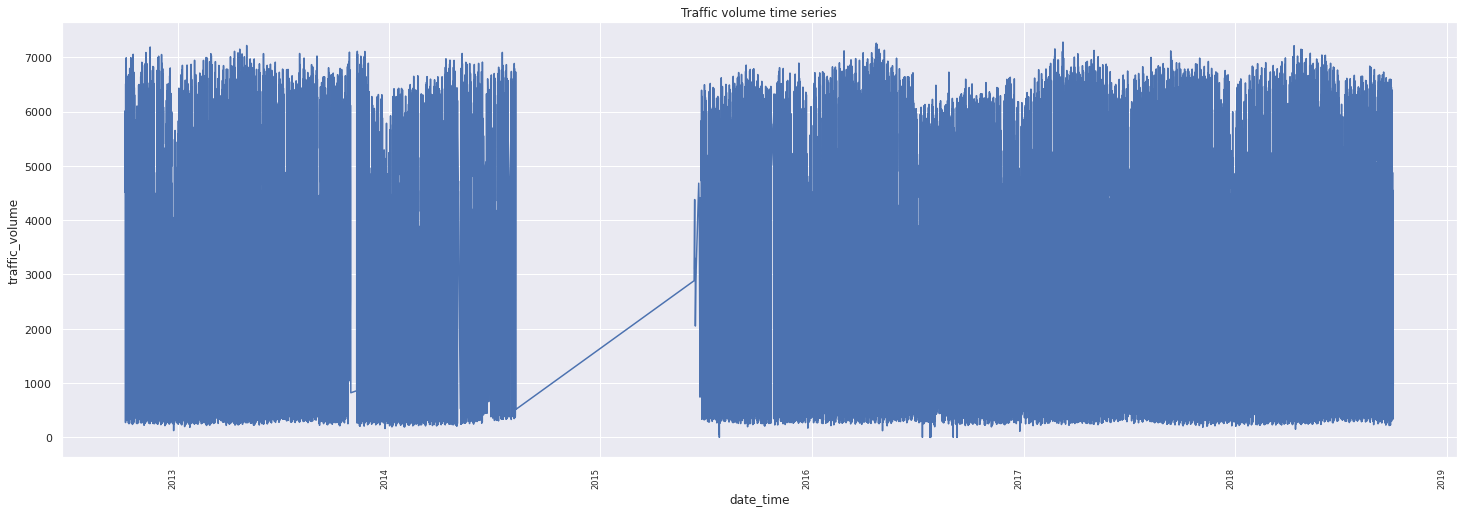

In [56]:
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-small'  
)
sns.lineplot(df_traffic.index, df_traffic["traffic_volume"]).set_title('Traffic volume time series')

In [57]:
## Check for missing values
#dummy data
date_range = pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='1H')
df_dummy = pd.DataFrame(np.random.randint(1, 20, (date_range.shape[0], 1)))
df_dummy.index = date_range  # set index
df_missing = df_traffic

#check for missing datetimeindex values based on reference index (with all values)
missing_hours = df_dummy.index[~df_dummy.index.isin(df_missing.index)]

print(missing_hours)

DatetimeIndex(['2012-10-03 07:00:00', '2012-10-03 10:00:00',
               '2012-10-03 11:00:00', '2012-10-03 17:00:00',
               '2012-10-05 02:00:00', '2012-10-05 04:00:00',
               '2012-10-06 03:00:00', '2012-10-07 01:00:00',
               '2012-10-07 02:00:00', '2012-10-09 03:00:00',
               ...
               '2018-03-24 05:00:00', '2018-03-24 06:00:00',
               '2018-03-24 07:00:00', '2018-03-29 02:00:00',
               '2018-05-05 02:00:00', '2018-06-02 02:00:00',
               '2018-08-07 07:00:00', '2018-08-07 08:00:00',
               '2018-08-07 09:00:00', '2018-08-23 02:00:00'],
              dtype='datetime64[ns]', length=11976, freq=None)


There are 11976 missing timestamps

In [58]:
df_traffic.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
traffic_volume         0
dtype: int64

In [59]:
# Inserting missing hours
df_traffic = df_traffic.reindex(pd.date_range(df_traffic.head(1).index[0], df_traffic.tail(1).index[0], freq='H'))
df_traffic.shape

(52551, 8)

In [60]:
df_traffic.isna().sum()

holiday                11976
temp                   11976
rain_1h                11976
snow_1h                11976
clouds_all             11976
weather_main           11976
weather_description    11976
traffic_volume         11976
dtype: int64

In [61]:
df_traffic['temp'].describe()

count    40575.000000
mean       281.315009
std         13.818404
min          0.000000
25%        271.840000
50%        282.860000
75%        292.280000
max        310.070000
Name: temp, dtype: float64

In [62]:
# Fill the temp value with median since 0 degree Kelvin is not possible
df_traffic['temp']=df_traffic['temp'].replace(0,df_traffic['temp'].median())


In [63]:
# Selecting only last 3 years data for further analysis
df_traffic = df_traffic[df_traffic.index.year.isin([2016,2017,2018])].copy()

# Filling missing values using backfill and interpolation methods
df_traffic = pd.concat([df_traffic.select_dtypes(include=['object']).fillna(method='backfill'),
                df_traffic.select_dtypes(include=['float']).interpolate()], axis=1)
df_traffic.shape

(24096, 8)

In [64]:
df_traffic = pd.get_dummies(df_traffic, columns = ['holiday', 'weather_main'], drop_first=True)
# df_traffic = pd.get_dummies(df_traffic, columns = ['weather_main'], drop_first=True)
df_traffic.drop('weather_description', axis=1, inplace=True)


In [65]:
print("Date starting from :",df_traffic.index.min())
print("Date end :",df_traffic.index.max())

Date starting from : 2016-01-01 00:00:00
Date end : 2018-09-30 23:00:00


In [66]:
df_traffic_train = df_traffic.loc[:datetime.datetime(year=2017,month=12,day=31,hour=23)]

print("Total number of row in train dataset:", df_traffic_train.shape[0])
print("Train dataset start date :",df_traffic_train.index.min())
print("Train dataset end date:",df_traffic_train.index.max())

Total number of row in train dataset: 17544
Train dataset start date : 2016-01-01 00:00:00
Train dataset end date: 2017-12-31 23:00:00


In [67]:
df_traffic_val = df_traffic.loc[datetime.datetime(year=2018,month=1,day=1,hour=0):datetime.datetime(year=2018,month=6,day=30,hour=23)]

print("Total number of row in validate dataset:", df_traffic_val.shape[0])
print("Validate dataset start date :",df_traffic_val.index.min())
print("Validate dataset end date:",df_traffic_val.index.max())

Total number of row in validate dataset: 4344
Validate dataset start date : 2018-01-01 00:00:00
Validate dataset end date: 2018-06-30 23:00:00


In [68]:
df_traffic_test = df_traffic.loc[datetime.datetime(year=2018,month=7,day=1,hour=0):]

print("Total number of row in validate dataset:", df_traffic_test.shape[0])
print("Validate dataset start date :",df_traffic_test.index.min())
print("Validate dataset end date:",df_traffic_test.index.max())

Total number of row in validate dataset: 2208
Validate dataset start date : 2018-07-01 00:00:00
Validate dataset end date: 2018-09-30 23:00:00


In [69]:
df_traffic_train.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
2016-01-01 00:00:00,265.940,0.0,0.0,90.0,1513.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 01:00:00,266.000,0.0,0.0,90.0,1550.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 02:00:00,266.005,0.0,0.0,90.0,1134.5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 03:00:00,266.010,0.0,0.0,90.0,719.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-01-01 04:00:00,264.800,0.0,0.0,90.0,533.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [70]:
#create scalers
temp_scaler = MinMaxScaler()
rain_scaler = MinMaxScaler()
snow_scaler = MinMaxScaler()
cloud_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()

#Create transformers
temp_scaler_transformer = temp_scaler.fit(df_traffic_train[['temp']])
rain_scaler_transformer = rain_scaler.fit(df_traffic_train[['rain_1h']])
snow_scaler_transformer = snow_scaler.fit(df_traffic_train[['snow_1h']])
cloud_scaler_transformer = cloud_scaler.fit(df_traffic_train[['clouds_all']])
volume_scaler_transformer = volume_scaler.fit(df_traffic_train[['traffic_volume']])

In [71]:
#Apply scaling to train dataset
df_traffic_train["temp"] = temp_scaler_transformer.transform(df_traffic_train[['temp']])
df_traffic_train["rain_1h"] = rain_scaler_transformer.transform(df_traffic_train[['rain_1h']])
df_traffic_train["snow_1h"] = snow_scaler_transformer.transform(df_traffic_train[['snow_1h']])
df_traffic_train["clouds_all"] = cloud_scaler_transformer.transform(df_traffic_train[['clouds_all']])
df_traffic_train["traffic_volume"] = volume_scaler_transformer.transform(df_traffic_train[['traffic_volume']])

In [72]:
#Apply scaling to validate dataset
df_traffic_val["temp"] = temp_scaler_transformer.transform(df_traffic_val[['temp']])
df_traffic_val["rain_1h"] = rain_scaler_transformer.transform(df_traffic_val[['rain_1h']])
df_traffic_val["snow_1h"] = snow_scaler_transformer.transform(df_traffic_val[['snow_1h']])
df_traffic_val["clouds_all"] = cloud_scaler_transformer.transform(df_traffic_val[['clouds_all']])
df_traffic_val["traffic_volume"] = volume_scaler_transformer.transform(df_traffic_val[['traffic_volume']])

#Apply scaling to test dataset
df_traffic_test["temp"] = temp_scaler_transformer.transform(df_traffic_test[['temp']])
df_traffic_test["rain_1h"] = rain_scaler_transformer.transform(df_traffic_test[['rain_1h']])
# df_traffic_test["snow_1h"] = snow_scaler_transformer.transform(df_traffic_test[['snow_1h']])
df_traffic_test["clouds_all"] = cloud_scaler_transformer.transform(df_traffic_test[['clouds_all']])
df_traffic_test["traffic_volume"] = volume_scaler_transformer.transform(df_traffic_test[['traffic_volume']])

In [73]:
class TrafficVolumeDataset(torch.utils.data.Dataset):
  def __init__(self, train=False, validate=False, test=False, window_size=480):

    #STEP1: Load the data
    self.df_traffic_train = df_traffic_train
    self.df_traffic_val = df_traffic_val
    self.df_traffic_test = df_traffic_test
    
    #STEP2: Creating Features
    if train: #process train dataset
      features = self.df_traffic_train
      target = self.df_traffic_train.traffic_volume
    elif validate: #process validate dataset
      features = self.df_traffic_val
      target = self.df_traffic_val.traffic_volume
    else: #process test dataset
      features = self.df_traffic_test
      target = self.df_traffic_test.traffic_volume
    
    #STEP3: Create windows/sequencing
    self.x, self.y = [], []
    for i in range(len(features) - window_size):
        v = features.iloc[i:(i + window_size)].values
        self.x.append(v)
        self.y.append(target.iloc[i + window_size])
    
    #STEP4: Calculate length of dataset
    self.num_sample = len(self.x)
    
  def __getitem__(self, index):
    x = self.x[index].astype(np.float32)
    y = self.y[index].astype(np.float32)
    return x, y

  def __len__(self):
    #returns the total number of records for data set
    return self.num_sample

In [74]:
traffic_volume =  TrafficVolumeDataset(test=True)

#let's loop it over single iteration and print the shape and also data
for i, (features,targets) in enumerate(traffic_volume):
  print("Size of the features",features.shape)
  print("Printing features:\n", features)
  print("Printing targets:\n", targets)
  break

Size of the features (480, 26)
Printing features:
 [[0.84078825 0.         0.         ... 0.         0.         0.        ]
 [0.8329684  0.         0.         ... 0.         0.         0.        ]
 [0.8251486  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.78026277 0.         0.         ... 0.         0.         0.        ]
 [0.7715045  0.         0.         ... 0.         0.         0.        ]
 [0.7636847  0.         0.         ... 0.         0.         0.        ]]
Printing targets:
 0.16964285


In [75]:
class TrafficVolumePrediction(pl.LightningModule):
  def __init__(self, input_size=26, output_size=1, hidden_dim=10, n_layers=2, window_size=480):
    """
    input_size: Number of features in the input
    hidden_dim: number of hidden layers 
    n_layers: number of RNN to stack over each other
    output_size: number of items to be outputted
    """
    super(TrafficVolumePrediction, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.TrafficVolumePrediction = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
    self.fc = nn.Linear(hidden_dim * window_size, output_size)

    self.loss = nn.MSELoss()

    self.learning_rate = 0.001

    # self.relu = nn.ReLU()

  def forward(self, x):
    batch_size = x.size(0)
    hidden = self.get_hidden(batch_size)
    out, hidden = self.TrafficVolumePrediction(x, hidden)
    # out = self.relu(out)
    out =out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

    
  def get_hidden(self, batch_size):
    # hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)

    hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    hidden = (hidden_state, cell_state)
    return hidden

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr = self.learning_rate)
    # optimizer = optim.RMSprop(params=params, lr = 0.001)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    features, targets = train_batch
    output = self(features) 
    output = output.view(-1)
    loss = self.loss(output, targets)
    self.log('train_loss', loss, prog_bar=True)
    return {"loss": loss}

  def train_dataloader(self):
    traffic_volume_train =  TrafficVolumeDataset(train=True)
    train_dataloader = torch.utils.data.DataLoader(traffic_volume_train, batch_size=50) 
    return train_dataloader
  
  def validation_step(self, val_batch, batch_idx):
    features, targets = val_batch
    output = self(features) 
    output = output.view(-1)
    loss = self.loss(output, targets)
    self.log('val_loss', loss, prog_bar=True)

  def val_dataloader(self):
    traffic_volume_val =  TrafficVolumeDataset(validate=True)
    val_dataloader = torch.utils.data.DataLoader(traffic_volume_val, batch_size=50) 
    return val_dataloader

In [76]:
seed_everything(10)
model = TrafficVolumePrediction()
trainer = pl.Trainer(max_epochs=140, gpus=1)
# Run learning rate finder
#lr_finder = trainer.tuner.lr_find(model, min_lr=1e-04, max_lr=1, num_training=30)
# Pick point based on plot, or get suggestion
#new_lr = lr_finder.suggestion()
#print("Suggested Learning Rate is :", new_lr)
# update hparams of the model
#model.hparams.lr = new_lr

Global seed set to 10
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
#print("model learning rate:",model.hparams)


In [ ]:
trainer.fit(model)



  | Name                    | Type    | Params
----------------------------------------------------
0 | TrafficVolumePrediction | LSTM    | 2.4 K 
1 | fc                      | Linear  | 4.8 K 
2 | loss                    | MSELoss | 0     
----------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 10


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
! ls lightning_logs

ls: cannot access 'lightning_logs': No such file or directory


In [ ]:
ls

'epoch=124-step=42749.ckpt'  'epoch=126-step=43433.ckpt'
'epoch=125-step=43091.ckpt'


In [ ]:
!ls lightning_logs/version_0/checkpoints


#Step 3- Checkpoint 

Edit this part of path to point to correct file name for saved checkpoint verison

In [ ]:
PATH = 'lightning_logs/version_00/checkpoints/epoch=139-step=47879.ckpt'

In [ ]:
#point to your own checkpoint directory
trained_traffic_volume_TrafficVolumePrediction = model.load_from_checkpoint(PATH)
trained_traffic_volume_TrafficVolumePrediction.eval()

In [ ]:
PATH = 'epoch=126-step=43433.ckpt'
trained_traffic_volume_TrafficVolumePrediction = model.load_from_checkpoint(PATH)
trained_traffic_volume_TrafficVolumePrediction.eval()

TrafficVolumePrediction(
  (TrafficVolumePrediction): LSTM(26, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4800, out_features=1, bias=True)
  (loss): MSELoss()
)

In [ ]:
#Initialize Dataset
traffic_volume_test_dataset =  TrafficVolumeDataset(test=True)
traffic_volume_test_dataloader = torch.utils.data.DataLoader(traffic_volume_test_dataset, batch_size=20) 
predicted_result, actual_result = [], []
#let's loop it over single iteration and print the shape and also data
for i, (features,targets) in enumerate(traffic_volume_test_dataloader):
  result = trained_traffic_volume_TrafficVolumePrediction(features)
  predicted_result.extend(result.view(-1).tolist())
  actual_result.extend(targets.view(-1).tolist())

In [ ]:
# actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
# actual_predicted_df

In [ ]:

actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
inverse_transformed_values = volume_scaler_transformer.inverse_transform(actual_predicted_df)
actual_predicted_df["actual"] = inverse_transformed_values[:,[0]]
actual_predicted_df["predicted"] = inverse_transformed_values[:,[1]]
actual_predicted_df

,actual,predicted
0,1234.999954,1069.377747
1,780.999981,408.802162
2,648.000016,307.989812
3,418.000002,165.850667
4,478.000026,29.801126
...,...,...
1723,3543.000033,2927.677855
1724,2780.999916,2529.127178
1725,2158.999898,1951.442294
1726,1449.999968,1314.058230


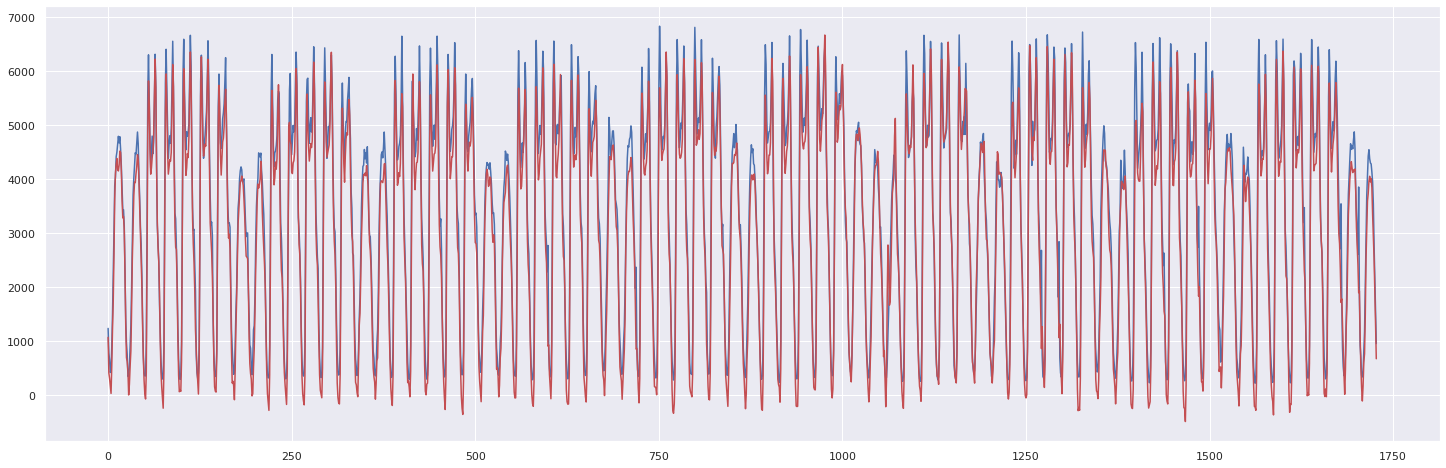

In [ ]:
plt.plot(actual_predicted_df["actual"],'b')
plt.plot(actual_predicted_df["predicted"],'r')
plt.show()